# Testing the Network

## Importing the Basics

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from machineLearning.nn.module import Sequential
from machineLearning.nn.optim import SGD, SGDMomentum, NesterovMomentum, AdaGrad, AdaDelta, RMSprop, Adam
from machineLearning.nn.scheduler import ExponentialLR, SteppedLR, CyclicalLR
from machineLearning.nn.loss import CrossEntropyLoss, MSELoss, NLLLoss, MAELoss, FocalLoss
from machineLearning.data import Data
from machineLearning.metric import ConfusionMatrix, Observables
from machineLearning import ModelIO, Progressbar
from machineLearning.nn.layer import (
    Linear, Dropout, Flatten, Convolution2D, Unsqueeze,
    BatchNorm1D, BatchNorm2D,
    Tanh, SoftMax, Sigmoid, SoftPlus, Relu, Elu, LeakyRelu, SoftSign, Identity
)
from machineLearning.nn import Quantizer

## Generating Test Data

Simple data set of 9x9 matrices with one somewhere down or along the matrix. This is for testing purposses only.

### Generating Data

In [2]:
categories = 4
data = Data(trainAmount=6400, evalAmount=3200, batchSize=128, kFold=4, dataPath='datafiles')
data.generateTestData(categories)

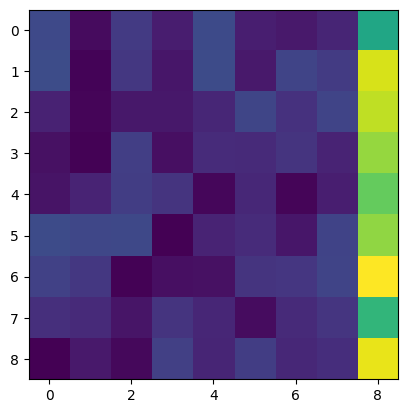

In [3]:
plt.imshow(data.trainSet.data[0])

## Creating a Sequential

This contains a list of layers, that are worked through one by one. Here I add a learning layer and after it an activation layer.

In [4]:
convolution = True
dropout = 0.35
norming = False
numLayers = 5

In [5]:
neurons = 81
network = Sequential()
if convolution is True:
    neurons = 147
    network.append(Unsqueeze((1,9,9)))
    network.append(Convolution2D(1,3))
    network.append(Tanh())
    if norming == True:
        network.append(BatchNorm2D((3,7,7)))

for i in range(numLayers-1):
    if i == 0:
        network.append(Flatten())
    network.append(Linear(neurons,neurons))
    network.append(Dropout(neurons,dropout))
    network.append(Tanh())
    if norming == True:
        network.append(BatchNorm1D(neurons))

network.append(Linear(neurons,categories))
network.append(SoftMax())
print(network)

(0) Unsqueeze    into shape: (1, 9, 9)
(1) Convolution2D    input channels: 1    output channels: 3    kernel size: (3, 3)    padding: (0, 0)    stride: (1, 1)
(2) Tanh
(3) Flatten
(4) Linear    input size: 147    output size: 147
(5) Dropout    size: 147    probability: 0.35
(6) Tanh
(7) Linear    input size: 147    output size: 147
(8) Dropout    size: 147    probability: 0.35
(9) Tanh
(10) Linear    input size: 147    output size: 147
(11) Dropout    size: 147    probability: 0.35
(12) Tanh
(13) Linear    input size: 147    output size: 147
(14) Dropout    size: 147    probability: 0.35
(15) Tanh
(16) Linear    input size: 147    output size: 4
(17) SoftMax



## Loss and Optimizer

Picking the loss function and initilizing the optimizer by handing over a list of layers.

In [6]:
loss = 'entropy'
optimizer = 'rmsprop'
learningRate = 0.001
momentum = 0.9
schedulerName = 'expo'
schedulerBool = False
decay = 0.9
stepSize = 10

In [7]:
if loss == 'entropy':
    lossFunc = CrossEntropyLoss()
elif loss == 'nllloss':
    lossFunc = NLLLoss()
elif loss == 'focal':
    lossFunc = FocalLoss()

if optimizer == 'sgd':
    optim = SGD(network, learningRate)
elif optimizer == 'momentum':
    optim = SGDMomentum(network, learningRate, momentum)
elif optimizer == 'nesterov':
    optim = NesterovMomentum(network, learningRate, momentum)
elif optimizer == 'adagrad':
    optim = AdaGrad(network, learningRate)
elif optimizer == 'adadelta':
    optim = AdaDelta(network, learningRate)
elif optimizer == 'rmsprop':
    optim = RMSprop(network, learningRate)
elif optimizer == 'adam':
    optim = Adam(network, learningRate)


if schedulerBool == True:
    if schedulerName == 'expo':
        scheduler = ExponentialLR(optim, decay)
    elif schedulerName == 'stepped':
        scheduler = SteppedLR(optim, decay, stepSize)
    elif schedulerName == 'else':
        scheduler = CyclicalLR(optim, 1/5, 15, 5)

## Running over Data

In [8]:
epochs = 25

In [9]:
metrics = Observables(epochs)
metrics.addOberservable('losses', 'descending')
metrics.addOberservable('validation', 'descending')
metrics.addOberservable('accuracy', 'ascending')
metrics.addOberservable('learningRate')


In [11]:
for i in range(epochs):
    data.trainMode()
    network.train()
    length = len(data.trainSet)
    bar = Progressbar(f'epoch {str(i+1).zfill(len(str(epochs)))}/{epochs}', length)
    for item in data.train:
        inputs = item.data
        labels = item.labels
        prediction = network(inputs)
        loss = lossFunc(prediction, labels)
        metrics.update('losses', loss, len(inputs) * (data.kFold - 1))
        gradient = lossFunc.backward()
        optim.step(gradient)
        bar.step()
    metrics.update('learningRate', optim.learningRate)
    data.evalMode()
    network.eval()
    for item in data.train:
        inputs = item.data
        labels = item.labels
        prediction = network(inputs)
        loss = lossFunc(prediction, labels)
        metrics.update('validation', loss, len(inputs))
        accuracy = np.sum(prediction.argmax(1) == labels.argmax(1)) / len(prediction)
        bar.step()
    if schedulerBool:
        scheduler.step()
    metrics.update('accuracy', accuracy)
    metrics.print()
    metrics.step()
    data.fold()

losses: 0.40543    validation: 0.06601    accuracy: 0.65625    learningRate: 0.001      
losses: 0.26853    validation: 0.04042    accuracy: 0.89844    learningRate: 0.001      
losses: 0.17346    validation: 0.04083    accuracy: 0.85156    learningRate: 0.001      
losses: 0.10087    validation: 0.01164    accuracy: 0.94531    learningRate: 0.001      
losses: 0.06189    validation: 0.00336    accuracy: 0.99219    learningRate: 0.001      
losses: 0.04818    validation: 0.00404    accuracy: 0.99219    learningRate: 0.001      
losses: 0.03574    validation: 0.0049     accuracy: 0.99219    learningRate: 0.001      
losses: 0.03304    validation: 0.00166    accuracy: 1.0        learningRate: 0.001      
losses: 0.02761    validation: 0.00769    accuracy: 1.0        learningRate: 0.001      
losses: 0.0237     validation: 0.00539    accuracy: 0.97656    learningRate: 0.001      
losses: 0.022      validation: 0.00094    accuracy: 0.99219    learningRate: 0.001      
losses: 0.02155    va

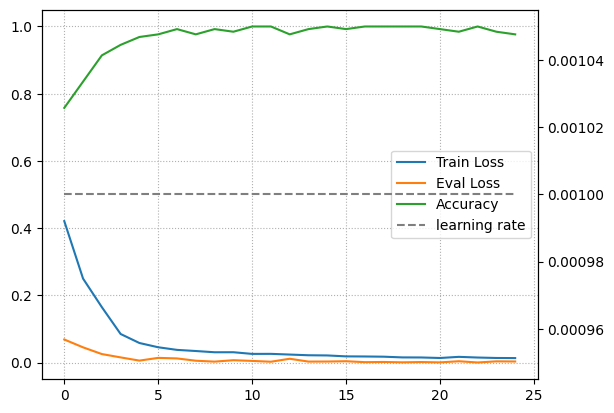

In [11]:
fig, ax = plt.subplots()
ax3 = ax.twinx()
lns1 = ax.plot(metrics.losses.values, label='Train Loss')
lns2 = ax.plot(metrics.validation.values, label='Eval Loss')
lns3 = ax.plot(metrics.accuracy.values, label='Accuracy')
lns4 = ax3.plot(metrics.learningRate.values, label='learning rate', color='tab:gray', ls='--')

lns = lns1+lns2+lns3+lns4
labs = [lab.get_label() for lab in lns]
ax.legend(lns, labs)

ax.grid(ls=':')

In [12]:
confusion = ConfusionMatrix(categories)
network.eval()
length = len(data.eval)
bar = Progressbar('evaluation', length)
for item in data.eval:
    inputs = item.data
    labels = item.labels
    prediction = network(inputs)
    confusion.update(prediction, labels)
    bar.step()
confusion.percentages()
confusion.calcScores()

evaluation |⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿| done ✔  | 96%


In [13]:
print(confusion)

━━━━━━━━━━━━━━━━━━━━━━━━ evaluation ━━━━━━━━━━━━━━━━━━━━━━━━
————————————————————— confusion matrix —————————————————————
              Class 0     Class 1     Class 2     Class 3   
····························································
     Class 0    3192         1           7           0      
                24%          0%          0%          0%     
····························································
     Class 1     1          3170         0           29     
                 0%         24%          0%          0%     
····························································
     Class 2     1           0          3198         1      
                 0%          0%         24%          0%     
····························································
     Class 3     0           0           0          3200    
                 0%          0%          0%         25%     

———————————————————————————————— scores ———————————————————————————————
            

## Saving and Loading a Sequential

Sequentilas can be converted to dictionaries and then saved as a json file. This allows us to load them and re-use them. Also json is a raw text format, which is neat.

In [14]:
ModelIO.save(network, 'network-test')
newNetwork = ModelIO.load('network-test')
print(newNetwork)

(0) Unsqueeze    into shape: (1, 9, 9)
(1) Convolution2D    input channels: 1    output channels: 3    kernel size: [3, 3]    padding: [0, 0]    stride: [1, 1]
(2) Tanh
(3) Flatten
(4) Linear    input size: 147    output size: 147
(5) Dropout    size: 147    probability: 0.35
(6) Tanh
(7) Linear    input size: 147    output size: 147
(8) Dropout    size: 147    probability: 0.35
(9) Tanh
(10) Linear    input size: 147    output size: 147
(11) Dropout    size: 147    probability: 0.35
(12) Tanh
(13) Linear    input size: 147    output size: 147
(14) Dropout    size: 147    probability: 0.35
(15) Tanh
(16) Linear    input size: 147    output size: 4
(17) SoftMax



In [15]:
newConfusion = ConfusionMatrix(categories)
newNetwork.eval()
length = len(data.eval)
bar = Progressbar('evaluation', length)
for item in data.eval:
    inputs = item.data
    labels = item.labels
    prediction = newNetwork(inputs)
    newConfusion.update(prediction, labels)
    bar.step()
newConfusion.percentages()
newConfusion.calcScores()
print(newConfusion)

evaluation |⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿| done ✔  | 96%
━━━━━━━━━━━━━━━━━━━━━━━━ evaluation ━━━━━━━━━━━━━━━━━━━━━━━━
————————————————————— confusion matrix —————————————————————
              Class 0     Class 1     Class 2     Class 3   
····························································
     Class 0    3192         1           7           0      
                24%          0%          0%          0%     
····························································
     Class 1     1          3170         0           29     
                 0%         24%          0%          0%     
····························································
     Class 2     1           0          3198         1      
                 0%          0%         24%          0%     
····························································
     Class 3     0           0           0          3200    
                 0%          0%          0%         25%     

——————

## Quantization

In [16]:
quantizer = Quantizer(scheme='symmetric')
quantizedModule = quantizer(network)
quantizer.addQuantizeLayer(quantizedModule)

In [17]:
fakeInput = np.random.randint(0,255,(4,147))

In [18]:
quantizedModule[6].weights.values

array([[ -7,  -7,   7, ...,  15, -42,  23],
       [  1,  -7, -10, ...,  -3, -17,  12],
       [-16,  -5,   2, ...,   0,  -3,  20],
       ...,
       [  8, -20, -16, ...,  36, -19,   9],
       [ 12, -13, -10, ..., -12, -36,  18],
       [ 11, -14, -27, ...,  19, -17,   9]], dtype=int32)

In [19]:
quantizedModule[6](fakeInput)

array([[ 107046, -127313,  -60812, -253564,  254273,  -90999, -210162,
        -129062,   91877,  -57847,  -79087,  227730, -287145, -146833,
         -51334,   35164, -213130, -222574, -117684, -288538, -129015,
          56632,   42171,   -2270, -100574,   67973,   34296,  265109,
         -10353,  158564,  -64287,  103533,  -77174,  -76748, -133277,
         222454, -222701,   44634, -120085,  -54471,  140314, -249767,
         -75681,   32365,   71243,   45702,  -37994, -270511,    2556,
         -52382,    2136, -199430,  215773,   59031, -251763,   56579,
         170038,   -4857,  162373, -131315,  -99432, -164802,  251620,
         -17751,   39198,   85264,   13333,  -49348,  142411,   -2692,
         259390,  111965,  102611, -192490,  -66971,  -60267, -135138,
        -215928,  160342,   59752, -270400,   21920,    3981,   67359,
         224517,  176747,  100451,   96596,  -11086,  135579,  -18238,
         -67520, -115459, -254757,   61731,   24313, -237876,  203624,
      

In [20]:
quantizedModule[7](quantizedModule[6](fakeInput))

array([[ 261, -310, -148, -617,  619, -221, -511, -314,  224, -141, -192,
         554, -699, -357, -125,   86, -519, -542, -286, -702, -314,  138,
         103,   -6, -245,  165,   83,  645,  -25,  386, -156,  252, -188,
        -187, -324,  541, -542,  109, -292, -133,  341, -608, -184,   79,
         173,  111,  -92, -658,    6, -127,    5, -485,  525,  144, -613,
         138,  414,  -12,  395, -320, -242, -401,  612,  -43,   95,  207,
          32, -120,  347,   -7,  631,  272,  250, -468, -163, -147, -329,
        -525,  390,  145, -658,   53,   10,  164,  546,  430,  244,  235,
         -27,  330,  -44, -164, -281, -620,  150,   59, -579,  496,  228,
        -122, -217, -656,  -18,   78,  289, -235,  -96, -275, -164,  -22,
         611,  162,   51,  258, -705, -610,  -32,  573, -445, -622,  336,
        -396,  190,  497,  256, -595,  210, -503,   44,   43, -130,   25,
         438, -219,   45,  110,  222,  -79, -253, -303,  234,  -27,   84,
        -161,  228, -656,  225],
     

In [21]:
print(quantizedModule)

(0) Quantize    bits: 8    scale: 1    zeroPoint: 0    scheme: symmetric
(1) Unsqueeze    into shape: (1, 9, 9)
(2) Convolution2D    input channels: 1    output channels: 3    kernel size: (3, 3)    padding: (0, 0)    stride: (1, 1)
(3) Accumulator    bits: 8    scale: 390.1296471075645    zeroPoint: 0    scheme: symmetric
(4) Tanh
(5) Flatten
(6) Linear    input size: 147    output size: 147
(7) Accumulator    bits: 8    scale: 410.91576668623816    zeroPoint: 0    scheme: symmetric
(8) Dropout    size: 147    probability: 0.35
(9) Tanh
(10) Linear    input size: 147    output size: 147
(11) Accumulator    bits: 8    scale: 252.2253183173983    zeroPoint: 0    scheme: symmetric
(12) Dropout    size: 147    probability: 0.35
(13) Tanh
(14) Linear    input size: 147    output size: 147
(15) Accumulator    bits: 8    scale: 356.3746548033485    zeroPoint: 0    scheme: symmetric
(16) Dropout    size: 147    probability: 0.35
(17) Tanh
(18) Linear    input size: 147    output size: 147
(19

In [22]:
quantConfusion = ConfusionMatrix(categories)
quantizedModule.eval()
length = len(data.eval)
bar = Progressbar('evaluation', length)
for item in data.eval:
    inputs = item['data']
    labels = item['labels']
    prediction = quantizedModule(inputs)
    quantConfusion.update(prediction, labels)
    bar.step()
quantConfusion.percentages()
quantConfusion.calcScores()
print(quantConfusion)

evaluation |⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿| done ✔  | 96%
————————————————————— confusion matrix —————————————————————
              Class 0     Class 1     Class 2     Class 3   
····························································
     Class 0     0           0          3200         0      
                 0%          0%         25%          0%     
····························································
     Class 1     0           0          3200         0      
                 0%          0%         25%          0%     
····························································
     Class 2     0           0          3200         0      
                 0%          0%         25%          0%     
····························································
     Class 3     0           0          3200         0      
                 0%          0%         25%          0%     



## Comment

The network works in principle and thanks to numpy, which is running on openblas, it even utilises multiple cores. I've added jupyter widgets to set network parameters.
The post training quantization (PTQ) doesn't shoot errors, but actually doesn't work yet, the network still runs fully unquantized.